# Mantenimiento Predictivo Basado en Datos de Equipamiento de Microsoft Azure

## Resumen

El objetivo es construir un modelo de ML para predecir cuando habrá un fallo en los equipos, apoyandose en datos de telemetria y reportes de fallos, errores y mantenimientos. Pero para predecir los posibles fallos, uno debe saber que falla, cuanto tiempo resiste, que valores son los influyentes y más. Por tanto, para analizar el comportamiento tanto de los equipos como del modelo generado y comprender la situación, se requiere conocer el proposito de las distintas variables y la relacion que tienen.

## Contexto

El mantenimiento predictivo es 
una solución que utiliza tecnicas de data analysis y tecnicas de detección de anomalias para mantener operativo el equipamiento que se puede reparar antes de que resulten en fallos.

Se escogio este tema por que idealmente se espera resolver problemas serios y dificiles como estos, manteniendo una manera efectiva de realizar mantenimiento reactivo sin incurrir a costos posteriores al desarrollo.

<img src="img/predictive-maintenance.jpg" width="800">

---
## Los datos 

Los datos estan en el folder "data", en este directorio encontraran 5 archivos:


### `PdM_errors.csv`

Es un archivo csv que contiene el registro de los errores que no rompen su funcionamiento y permiten al sistema seguir siendo funcional, asi que no se nombran como fallos.

**Ejemplo:**
~~~
     datetime            machineID    errorID
2015-01-03 07:00:00         1          error1
2015-01-03 20:00:00         1          error3
2015-01-04 06:00:00         1          error5
(...)
~~~

### `PdM_failures.csv`

Es un archivo csv que contiene el registro de los componentes que se tienen que reemplazar debido a fallos donde se guarda la fecha en que se arruino, la maquina que fue y el tipo de componente que fallo., 

**Ejemplo:**
~~~
     datetime            machineID    failure
2015-01-05 06:00:00         1          comp4
2015-03-06 06:00:00         1          comp1
2015-04-20 06:00:00         1          comp2
(...)
~~~

### `PdM_machines.csv`

Es un archivo csv que incluye la meta data sobre las maquinas, ya que involucra el modelo que es el equipo y la cantidad de años en servicio que tiene.


~~~
machineID    model       age
    1        model3      18
    2        model4       7
    3        model3       8
(...)
~~~

### `PdM_maint.csv`
Es un archivo csv que contiene los registros de mantenimientos programados y no programados para la inspección de componentes, asi como sus fallos. Estos normalmente se generan si se reemplaza un componente debido a esa inspección o debido a un colapso del sistema. Estos son los registros del 2014 y 2015.

**Ejemplo:**
~~~
     datetime            machineID    comp
2014-06-01 06:00:00         1         comp2
2014-07-16 06:00:00         1         comp4
2014-07-31 06:00:00         1         comp3
(...)
~~~

### `PdM_telemetry.csv`

Es un archivo csv que contiene la información de telemetria de los equipos, que consiste de datos medibles colectados de 100 maquinas en tiempo real, donde esas medidas se promedian cada hora durante el año 2015. 

**Ejemplo:**
~~~
     datetime       machineID         volt            rotate          pressure         vibration
2015-01-01 06:00:00    1       176.217853015625 418.504078221616 113.077935462083  45.0876857639276
2015-01-01 07:00:00    1       162.87922289706  402.747489565395 95.4605253823187  43.4139726834815
2015-01-01 08:00:00    1       170.989902405567 527.349825452291 75.2379048586662  34.1788471214451
(...)
~~~

**This dataset was available as a part of Azure AI Notebooks for Predictive Maintenance, current versions are no longer available.**

---

## Paso 1:_ Cargar los datos

---

Lo primero que se hace es cargar las librerias que se emplearan, asi como cargar los archivos que se emplearan y crear métodos que usaremos a futuro, pero no necesitamos conocer directamente a profundidad:

In [104]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, mean_squared_error

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plotMachineRecords(telemetry_records):
    plt.figure(figsize=(20,4))
    for telemetry_feature in telemetry_features:
        plt.plot(telemetry_records.index, telemetry_records[telemetry_feature])
def plotErrorsAndFailures():
    fails = failures.groupby('datetime').mean().groupby(pd.Grouper(freq="1D")).mean()
    fails = fails[fails['machineID'].notna()]
    groupederrors = errors.groupby('datetime').mean().groupby(pd.Grouper(freq="1D")).mean()
    groupederrors = groupederrors[groupederrors['machineID'].notna()]
    for date in fails.index:
        plt.axvline(date, color = 'black', label = 'axvline - full height', lw = 2)
    for date in groupederrors.index:
        plt.axvline(date, color = 'purple', label = 'axvline - full height', linestyle = '--')
    plt.legend(telemetry_features + ['Errors', 'Failures'], loc = 'upper right')
    plt.xlabel('Time')
    plt.ylabel('Value of Telemetry Data')
    plt.title('Errors and Failures through Time For All Machines')
def plotMachineRecordsForSegments(m_list, telemetry_records):
    segmented_fails = failures[failures.apply(lambda x: x['machineID'] in m_list, axis=1)].groupby('datetime').mean().groupby(pd.Grouper(freq="1D")).mean()
    segmented_fails = segmented_fails[segmented_fails['machineID'].notna()]
    segmented_groupederrors = errors[errors.apply(lambda x: x['machineID'] in m_list, axis=1)].groupby('datetime').mean().groupby(pd.Grouper(freq="1D")).mean()
    segmented_groupederrors = segmented_groupederrors[segmented_groupederrors['machineID'].notna()]
    plt.figure(figsize=(25,4))
    for telemetry_feature in telemetry_features:
        plt.plot(telemetry_records.index, telemetry_records[telemetry_feature])
    for date in segmented_fails.index:
        plt.axvline(date, color = 'black', label = 'axvline - full height', lw = 2)
    for date in segmented_groupederrors.index:
        plt.axvline(date, color = 'purple', label = 'axvline - full height', linestyle = '--')
    plt.legend(telemetry_features + ['Errors', 'Failures'], loc = 'upper right')
    plt.xlabel('Time')
    plt.ylabel('Value of Telemetry Data')
    plt.title('Telemetry Values through Time')

Posteriormente cargamos los datasets que emplearemos, asi como modificamos sus fechas que fueron guardadas como string

In [3]:
errors =  pd.read_csv('data/PdM_errors.csv')
errors['datetime'] = pd.to_datetime(errors['datetime'])

failures =  pd.read_csv('data/PdM_failures.csv')
failures['datetime'] = pd.to_datetime(failures['datetime'])

machines =  pd.read_csv('data/PdM_machines.csv')

maint =  pd.read_csv('data/PdM_maint.csv')
maint['datetime'] = pd.to_datetime(maint['datetime'])

telemetry =  pd.read_csv('data/PdM_telemetry.csv')
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
telemetry_features = ['volt', 'rotate', 'pressure', 'vibration']

scaler = StandardScaler()

---

## Paso 1: Conocer los datos

---

Primero veremos la cantidad de los modelos que existen y cuantas veces se cambiaron los componentes que se cambiaron 

Text(0.5, 1.0, 'Components')

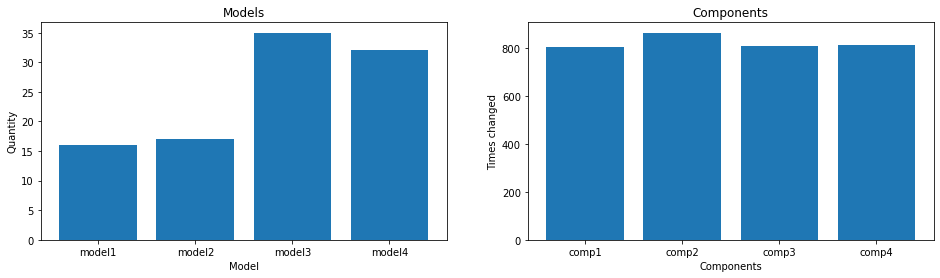

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))
models = machines.groupby('model').size()
components = maint.groupby('comp').size()
axs[0].bar(models.index, models.values)
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Quantity')
axs[0].set_title('Models')
axs[1].bar(components.index, components.values)
axs[1].set_xlabel('Components')
axs[1].set_ylabel('Times changed')
axs[1].set_title('Components')

Se observa que **hay casi el doble de modelos 3 y 4 que los que hay del modelo 1 y 2 del total**, sin embargo, **la cantidad de veces que se cambiaron los componentes en total es similar**, asi que podemos empezar a hacer supocisiones para las preguntas que se realizaran sobre que equipos fallan más.

Posteriormente, vemos solo de los 10 equipos más antiguos y nuevos y notamos, que no hay mucha varianza en cuanto al panorama general, ya que practicamente **hay al menos el doble de modelos** 3 y 4 que los modelos 1 y 2. 

Text(0.5, 1.0, 'Youngest models')

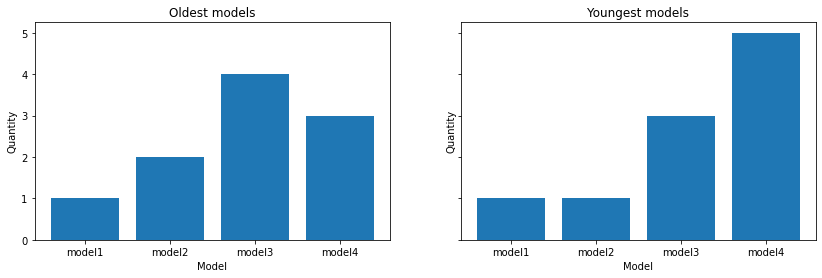

In [5]:
youngest_machine = machines[machines['age'] == np.min(machines['age'])].index[0]
oldest_machine = machines[machines['age'] == np.max(machines['age'])].index[1]

oldest_machines = machines.sort_values('age', ascending=False).iloc[:10]
youngest_machines = machines.sort_values('age').iloc[:10]

oldest_models = oldest_machines.groupby('model').size()
youngest_models = youngest_machines.groupby('model').size()

fig, axs = plt.subplots(1, 2, figsize=(14,4), sharey=True)
axs[0].bar(oldest_models.index, oldest_models.values)
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Quantity')
axs[0].set_title('Oldest models')
axs[1].bar(youngest_models.index, youngest_models.values)
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Quantity')
axs[1].set_title('Youngest models')

Text(0.5, 1.0, 'Models in use by years')

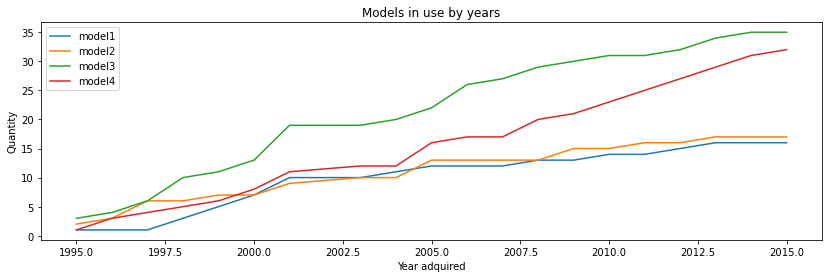

In [6]:
models_year = machines.groupby(['age', 'model'], as_index=False).count().pivot(index='age', columns='model', values='machineID')[::-1]
models_year.index = 2015 - models_year.index
models_year = models_year.fillna(0)
models_year = models_year.cumsum()

plt.figure(figsize=(14,4))
plt.plot(models_year.index, models_year)
plt.legend(models_year.columns)
plt.xlabel('Year adquired')
plt.ylabel('Quantity')
plt.title('Models in use by years')

Tambien queremos saber sobre los valores de telemetria que los equipos tienen, para esto veremos en un plot como cambia el promedio de todos los equipos para el tiempo:

Text(0.5, 1.0, 'Telemetry Values through Time')

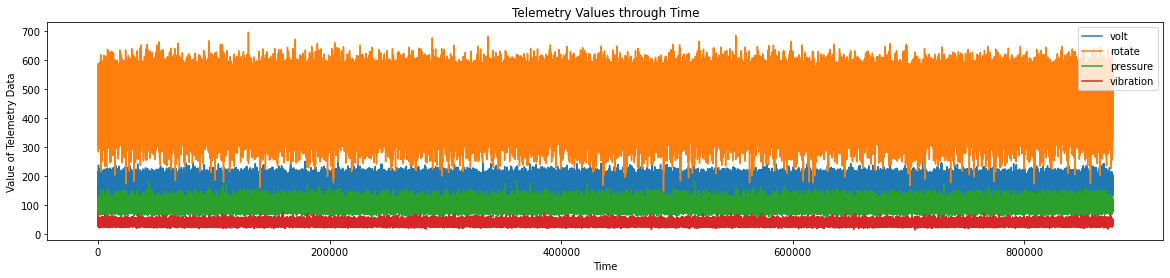

In [7]:
plotMachineRecords(telemetry)
plt.legend(telemetry_features, loc = 'upper right')
plt.xlabel('Time')
plt.ylabel('Value of Telemetry Data')
plt.title('Telemetry Values through Time')

Wow, es bastante complicado apreciar los valores, ¿Verdad? Eso es por que las lecturas de los valores son cada hora, para
aliviar la vista, demosle una frecuencia de cada 2 días para observarlo mejor

Text(0.5, 1.0, 'Telemetry Values through Time')

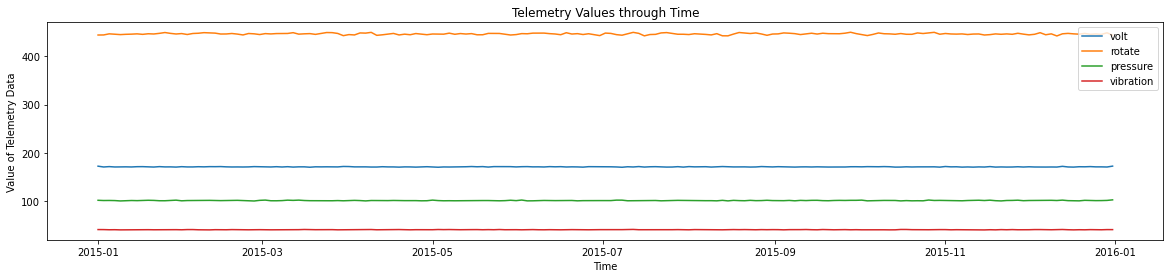

In [8]:
telemetry_values_total = telemetry.groupby('datetime').mean().groupby(pd.Grouper(freq="2D")).mean()
plotMachineRecords(telemetry_values_total)
plt.legend(telemetry_features, loc = 'upper right')
plt.xlabel('Time')
plt.ylabel('Value of Telemetry Data')
plt.title('Telemetry Values through Time')

Ahora los datos parecen bastante planos, tal vez sea por que es el promedio de todas las máquinas, que tal si agarramos solo una muestra del 10% de las máquinas al azar.

C:\Users\bramo\.conda\envs\data_science\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Text(0.5, 1.0, 'Telemetry Values through Time of a 10% sample of Machines')

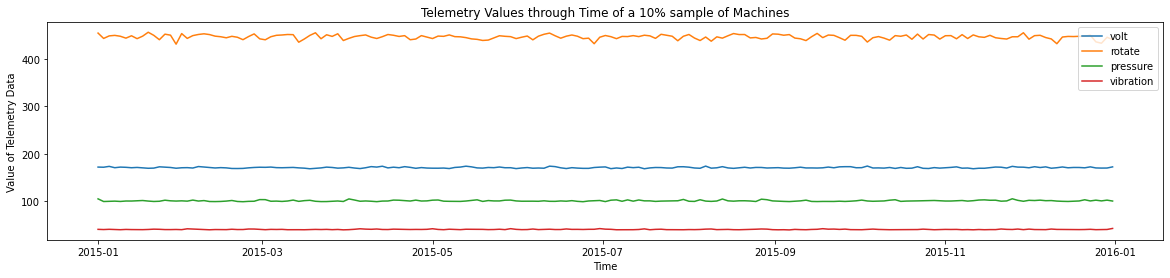

In [9]:
machine_list = machines.sample(frac=0.1)['machineID'].tolist()
# Obtenemos los valores promedio de telemetría de solo el 10% del total de máquinas a través del tiempo en una frecuencia de 2 días ya que hay mucho ruido entre valores
segment_telemetry = telemetry[telemetry.apply(lambda x: x['machineID'] in machine_list, axis=1)]
segment_telemetry.drop('machineID', inplace=True, axis=1)
segmented_data = segment_telemetry.groupby('datetime').mean().groupby(pd.Grouper(freq="2D")).mean()
plotMachineRecords(segmented_data)
plt.legend(telemetry_features, loc = 'upper right')
plt.xlabel('Time')
plt.ylabel('Value of Telemetry Data')
plt.title('Telemetry Values through Time of a 10% sample of Machines')

Va bien, podemos notar más picos y curvas de la telemetria, pero a pesar de ello, esto no dice mucho, 
¿Verdad? Que tal si añadimos los errores y los failures para ver que significan los picos de los valores.

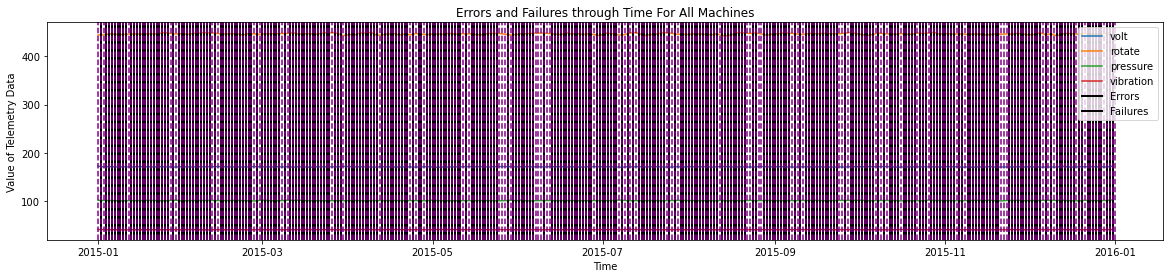

In [10]:
plotMachineRecords(telemetry_values_total)
plotErrorsAndFailures()

 Sin embargo, vemos que practicamente hay un error o failure casi cada dia o más de una vez por día, asi que, ¿Qué tal sobre las 10 maquinas?

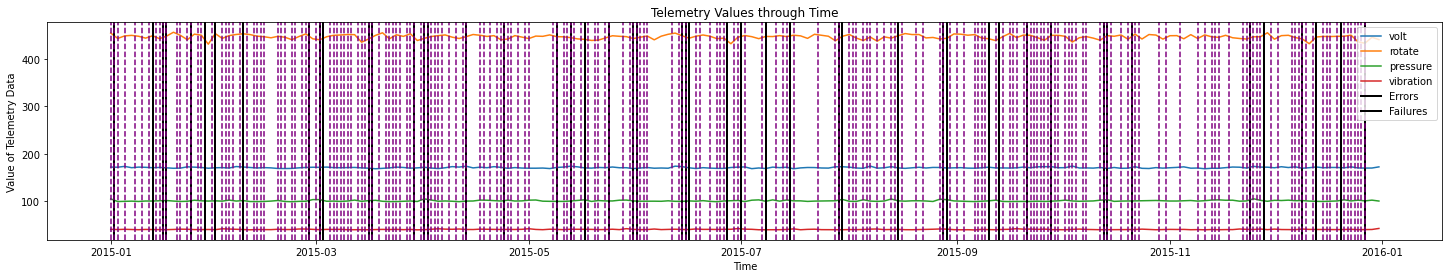

In [11]:
plotMachineRecordsForSegments(machine_list, segmented_data)

Siguen siendo un monton, ¿Verdad? Entonces que tal solo de 2 máquinas al azar

C:\Users\bramo\.conda\envs\data_science\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


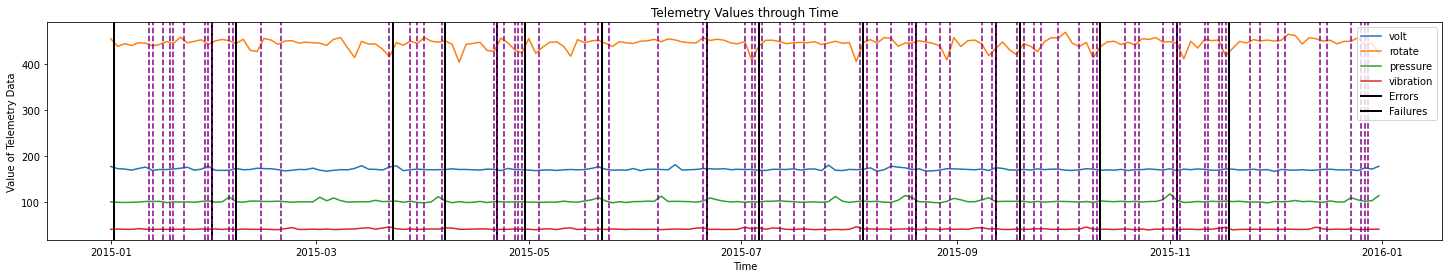

In [12]:
machine_list2 = machines.sample(frac=0.02)['machineID'].tolist()
# Obtenemos los valores promedio de telemetría de solo el 10% del total de máquinas a través del tiempo en una frecuencia de 2 días ya que hay mucho ruido entre valores
segment_telemetry2 = telemetry[telemetry.apply(lambda x: x['machineID'] in machine_list2, axis=1)]
segment_telemetry2.drop('machineID', inplace=True, axis=1)
segmented_data2 = segment_telemetry2.groupby('datetime').mean().groupby(pd.Grouper(freq="2D")).mean()

plotMachineRecordsForSegments(machine_list2, segmented_data2)

¡Ahora podemos apreciarlo! A simple vista podemos ver que **siempre hay un pico en algún valor de telemetria cercano a una falla, pero no son picos muy prominentes para los errores**.

Asi mismo, queremos ver si existe una relación a simple vista entre la cantidad de mantenimientos realizados, los errores que suceden y los fallos que pasan a travez del año 2015, pero como vimos antes, ¡Son demasiados! Asi que esta vez, reduciremos el ruido agrupandolos por cada semana.

Text(0.5, 1.0, 'Counter of data of machines')

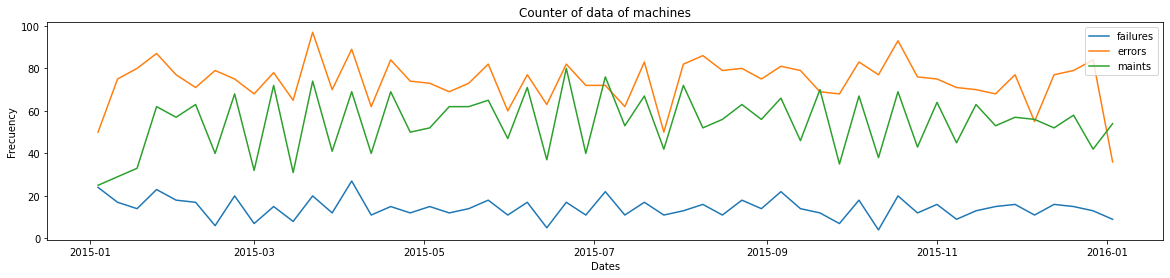

In [13]:
failures_week = failures.groupby('datetime').count().groupby(pd.Grouper(freq="1W")).sum()
errors_week = errors.groupby('datetime').count().groupby(pd.Grouper(freq="1W")).sum()
maint_week = maint[maint['datetime'] >= pd.to_datetime('2015-01-01')].groupby('datetime').count().groupby(pd.Grouper(freq="1W")).sum()

plt.figure(figsize=(20,4))
plt.plot(failures_week.index, failures_week['machineID'])
plt.plot(errors_week.index, errors_week['machineID'])
plt.plot(maint_week.index, maint_week['machineID'])
plt.legend(['failures', 'errors', 'maints'], loc = 'upper right')
plt.xlabel('Dates')
plt.ylabel('Frecuency')
plt.title('Counter of data of machines')

Text(0.5, 1.01, 'Correlation between frecuency of failures, errors and maintenances')

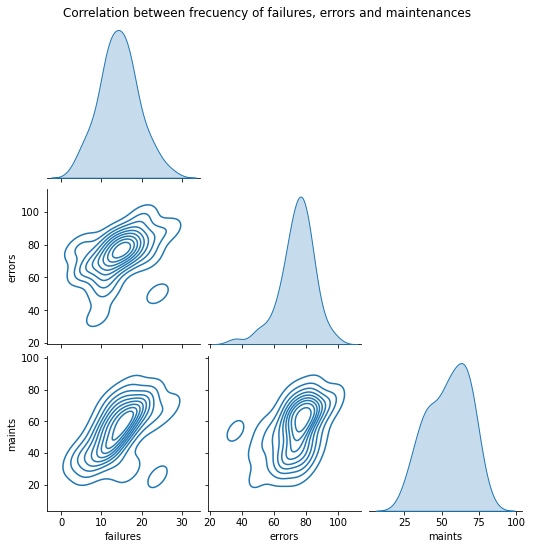

In [14]:
bad_machines_week = pd.DataFrame({})
bad_machines_week['failures'] = failures_week['machineID']
bad_machines_week['errors'] = errors_week['machineID']
bad_machines_week['maints'] = maint_week['machineID']

sns.pairplot(bad_machines_week, corner=True, kind='kde').fig.suptitle('Correlation between frecuency of failures, errors and maintenances', y=1.01)

Text(0.5, 1.0, 'Change of components through time')

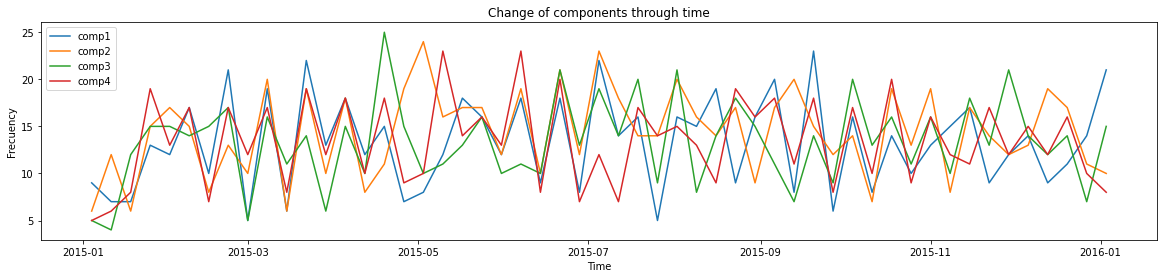

In [15]:
maint_2015 = maint[maint['datetime'] >= pd.to_datetime('2015-01-01')]

maint_2015_comp = maint_2015.groupby(['datetime', 'comp'], as_index=False).count().pivot(index='datetime', columns='comp', values='machineID')
maint_2015_comp = maint_2015_comp.fillna(0)
maint_2015_comp_week = maint_2015_comp.groupby(pd.Grouper(freq="1W")).sum()

plt.figure(figsize=(20,4))
for comp in components.index:
    plt.plot(maint_2015_comp_week.index, maint_2015_comp_week[comp])
plt.legend(maint.groupby('comp').count().index)
plt.xlabel('Time')
plt.ylabel('Frecuency')
plt.title('Change of components through time')

Text(0.5, 0.98, 'Correlation between frecuency of component maintenance')

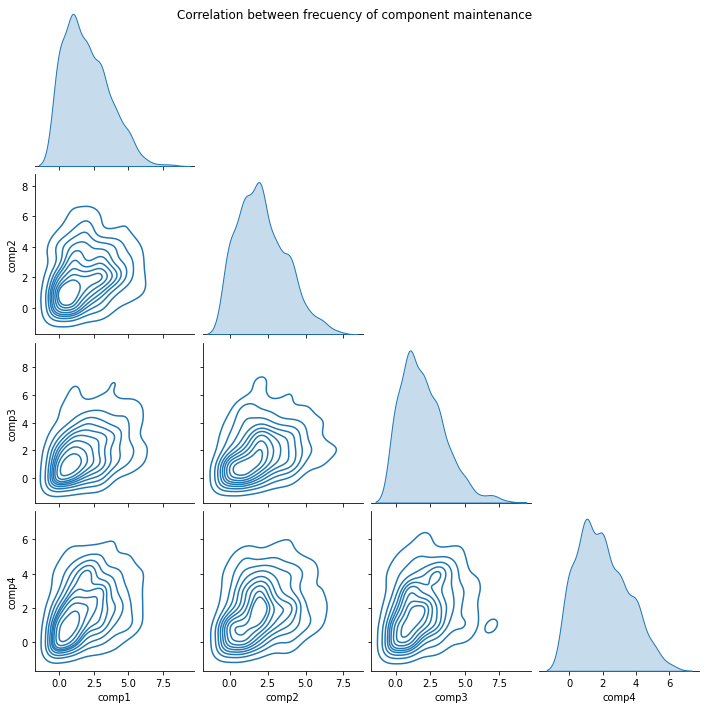

In [16]:
sns.pairplot(maint_2015_comp, corner=True, kind='kde').fig.suptitle('Correlation between frecuency of component maintenance')

In [17]:
maint_2015_comp.corr(method='pearson')

comp,comp1,comp2,comp3,comp4
comp,,,,
comp1,1.000000,0.231715,0.311730,0.298235
comp2,0.231715,1.000000,0.303169,0.303488
comp3,0.311730,0.303169,1.000000,0.302185
comp4,0.298235,0.303488,0.302185,1.000000


#### ¿Qué modelo de equipamiento son los mas propensos a fallar?

Primero se necesita agrupar la información que concierne la pregunta

Text(0.5, 1.0, 'Mean failures by model')

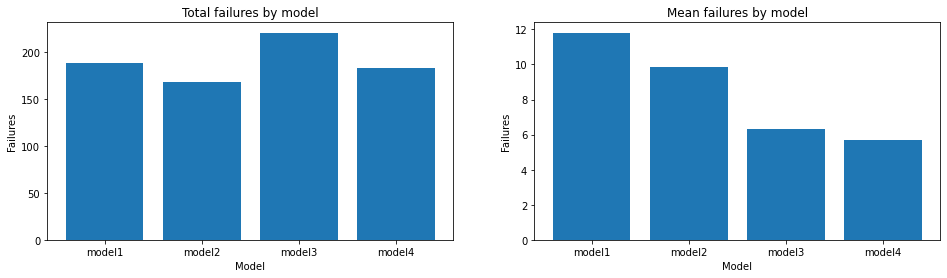

In [18]:
models_failures = machines.copy()
models_failures['failures'] = models_failures.apply(lambda x: len(failures[failures['machineID'] == x['machineID']]), axis=1)
models_failures_total = models_failures.groupby('model').sum()
models_failures_mean = models_failures.groupby('model').mean()

fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].bar(models_failures_total.index, models_failures_total['failures'])
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Failures')
axs[0].set_title('Total failures by model')
axs[1].bar(models_failures_mean.index, models_failures_mean['failures'])
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Failures')
axs[1].set_title('Mean failures by model')

In [19]:
\#Escribir respuesta

#### ¿Cuáles son las causas mas comunes que provocan los fallos y con que piezas se tienden a reemplazar?

In [103]:
#Selection of train and test data
#maint_train = pd.get_dummies(maint)
#maint_train = maint_train.groupby(['datetime', 'machineID'], as_index=False).sum()

errors_train = pd.get_dummies(errors)
errors_train = errors_train.groupby(['datetime', 'machineID'], as_index=False).sum()

failures_train = pd.get_dummies(failures)
failures_train = failures_train.groupby(['datetime', 'machineID'], as_index=False).sum()

#telemetry_train = telemetry.merge(maint_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
#telemetry_train = telemetry_train.merge(errors_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry.merge(errors_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.merge(failures_train, how='left', left_on=['datetime', 'machineID'], right_on=['datetime', 'machineID'])
telemetry_train = telemetry_train.fillna(0)
telemetry_train.sort_values('datetime', inplace=True)

features = ['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'errorID_error1', 'errorID_error2', 'errorID_error3', 'errorID_error4', 'errorID_error5']
labels = ['failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4']

X = telemetry_train[features]
X = StandardScaler().fit_transform(X)
#X = PCA(n_components=2).fit_transform(X)
y = telemetry_train[labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69, shuffle=False)
telemetry_train

,datetime,machineID,volt,rotate,pressure,vibration,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5,failure_comp1,failure_comp2,failure_comp3,failure_comp4
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
455572,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858578,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96371,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43805,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613269,2016-01-01 06:00:00,70,188.135372,457.661580,89.725251,42.932201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
622030,2016-01-01 06:00:00,71,174.028202,349.326013,111.231561,38.669674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630791,2016-01-01 06:00:00,72,183.176861,381.242172,104.658441,38.504998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
648313,2016-01-01 06:00:00,74,188.299688,494.616310,101.785150,41.609665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Stochastic Gradient Descent
#clf_sgc = OneVsRestClassifier(SGDClassifier()).fit(X, y)
clf_sgc = MultiOutputClassifier(SGDClassifier()).fit(X, y)
clf_sgc = ClassifierChain(SGDClassifier()).fit(X, y)
y_pred = clf_sgc.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred, average='micro'))
print('recall:', recall_score(y_test, y_pred, average='micro', zero_division=0))
print('f1:', f1_score(y_test, y_pred, average='micro'))
print('mean_squared_error:', mean_squared_error(y_test, y_pred))

accuracy: 0.9992390518586158
precision: 0.0


C:\Users\bramo\.conda\envs\data_science\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall: 0.0
f1: 0.0
mean_squared_error: 0.00020061360091037066


In [96]:
# Stochastic Gradient Descent with Kernel Approximation
X_rbf = RBFSampler(gamma=1, random_state=1).fit_transform(X)
X_rbf_train, X_rbf_test, y_rbf_train, y_rbf_test = train_test_split(X_features, y, test_size=0.33, random_state=69, shuffle=False)

#clf_sgc = OneVsRestClassifier(SGDClassifier()).fit(X_rbf_train, y_rbf_train)
clf_sgc = MultiOutputClassifier(SGDClassifier()).fit(X_rbf_train, y_rbf_train)
clf_sgc = ClassifierChain(SGDClassifier()).fit(X_rbf_train, y_rbf_train)

y_pred = clf_sgc.predict(X_rbf_test)
print('accuracy:', accuracy_score(y_rbf_test, y_pred))
print('precision:', precision_score(y_rbf_test, y_pred, average='micro'))
print('recall:', recall_score(y_rbf_test, y_pred, average='micro', zero_division=0))
print('f1:', f1_score(y_rbf_test, y_pred, average='micro'))
print('mean_squared_error:', mean_squared_error(y_rbf_test, y_pred))

accuracy: 0.9992390518586158
precision: 0.0


C:\Users\bramo\.conda\envs\data_science\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall: 0.0
f1: 0.0
mean_squared_error: 0.00020061360091037066


In [81]:
# Decision Tree
clf_dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
y_pred = clf_dt.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred, average='micro'))
print('recall:', recall_score(y_test, y_pred, average='micro', zero_division=0))
print('f1:', f1_score(y_test, y_pred, average='micro'))
print('mean_squared_error:', mean_squared_error(y_test, y_pred))

In [105]:
# Multi-layer Perceptron

clf_mlp = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred, average='micro'))
print('recall:', recall_score(y_test, y_pred, average='micro', zero_division=0))
print('f1:', f1_score(y_test, y_pred, average='micro'))
print('mean_squared_error:', mean_squared_error(y_test, y_pred))

accuracy: 0.9992390518586158
precision: 0.0


C:\Users\bramo\.conda\envs\data_science\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall: 0.0
f1: 0.0
mean_squared_error: 0.00020061360091037066


In [106]:
np.sum(y_pred)

0

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(maint.groupby('comp').count().index, maint.groupby('comp').count()['machineID'])
plt.xlabel('Component')
plt.ylabel('Number of replacements')
plt.title('Replacements by component')

#### ¿Existe relación entre las fechas de los fallos con algun evento en especifico? Por ejemplo un apagon masivo, en cuyo caso, ¿Qué información podría proveer?

In [ ]:
plt.figure(figsize=(20,5))

failures_1 = failures.copy()
df_errors_3 = failures_1.groupby(["datetime"]).size().reset_index(name='counts')
plt.plot(df_errors_3.datetime, df_errors_3['counts'])
plt.legend(['counts'])
plt.xlabel('Date of failure')
plt.ylabel('Number of failures')
plt.title('Number of failures per day')

#### ¿Tendrá relación la cantidad de años en servicio y el promedio de fallos en dicho tiempo? Sera posible que a medida que más envejezca, más propenso sea a tener errores o seguira igual.

In [ ]:
machines_exhaustion = machines.copy()
machines_exhaustion['errors'] = machines.apply(lambda x: len(errors[errors['machineID'] == x['machineID']]), axis=1)
machines_exhaustion['failures'] = machines.apply(lambda x: len(failures[failures['machineID'] == x['machineID']]), axis=1)
machines_exhaustion_age = machines_exhaustion.groupby('age').mean()

fig, axs = plt.subplots(1, 2, figsize=(20,4))
axs[0].plot(machines_exhaustion_age.index, machines_exhaustion_age['errors'])
axs[0].set_xlabel('Time in service (years)')
axs[0].set_ylabel('Frecuency')
axs[0].set_title('Errors by time of service')
axs[1].plot(machines_exhaustion_age.index, machines_exhaustion_age['failures'])
axs[1].set_xlabel('Time in service (years)')
axs[1].set_ylabel('Frecuency')
axs[1].set_title('Failures by time of service')

#### ¿Qué relacion existe entre las variables de telemetria? Siendo este análisis el más importante, ¿Podemos encontrar las relaciones pertinentes entre las fallas y las variables de telemetria que corresponden? ¿Cómo podríamos identificar las irregularidades para predecir que va a fallar a futuro?

In [ ]:
sns.pairplot(telemetry[telemetry_features], corner=True, kind='hist').fig.suptitle('Correlation of telemetry values')
##LO MISMO CON FALLOS Y ERRORES

In [ ]:
telemetry[telemetry_features].corr(method='pearson')

In [ ]:
'''
def plotMachineRecords(machineID, telemetry_records):
    plt.figure(figsize=(20,4))
    for telemetry_feature in telemetry_features:
        plt.plot(telemetry_records.index, telemetry_records[telemetry_feature])
    for date in failures[(failures['machineID'] == machineID) & (failures['datetime'] >= pd.to_datetime('2015-01-01'))]['datetime']:
        plt.axvline(date, color = 'black', label = 'axvline - full height', lw = 2)
    for date in errors[(errors['machineID'] == machineID) & (errors['datetime'] >= pd.to_datetime('2015-01-01'))]['datetime']:
        plt.axvline(date, color = 'purple', label = 'axvline - full height', linestyle = '--')
    plt.legend(telemetry_features + ['failures', 'errors'])
    plt.xlabel('Time')
telemetry_week_youngest = telemetry[telemetry['machineID'] == youngest_machine].groupby('datetime').mean().groupby(pd.Grouper(freq="2D")).mean()
plotMachineRecords(youngest_machine, telemetry_week_youngest)
plt.ylabel('Values of telemetry')
plt.title('Telemetry and failures of youngest machine')

telemetry_week_oldest = telemetry[telemetry['machineID'] == oldest_machine].groupby('datetime').mean().groupby(pd.Grouper(freq="2D")).mean()
plotMachineRecords(oldest_machine, telemetry_week_oldest)
plt.ylabel('Values of telemetry')
plt.title('Telemetry and failures of oldest machine')

scaler.fit(telemetry_week_youngest)
telemetry_week_youngest_scaled = pd.DataFrame(scaler.transform(telemetry_week_youngest), telemetry_week_youngest.index, telemetry_week_youngest.columns)
plotMachineRecords(youngest_machine, telemetry_week_youngest_scaled)
plt.ylabel('Scaled values of telemetry')
plt.title('Scaled telemetry and failures of youngest machine')

scaler.fit(telemetry_week_oldest)
telemetry_week_oldest_scaled = pd.DataFrame(scaler.transform(telemetry_week_youngest), telemetry_week_youngest.index, telemetry_week_youngest.columns)
plotMachineRecords(oldest_machine, telemetry_week_oldest_scaled)
plt.ylabel('Scaled values of telemetry')
plt.title('Scaled telemetry and failures of oldest machine')
'''